# Finding Cause-Effects : PC Stable Algorithm

---
This notebook provides a simple example of how the PC stable algorithm can be used to find potential cause-effect relationships between a set of time series variables. 
This is written as a tutorial for atmospheric science applications and is part of the Data Analysis Tools for Atmospheric Scientists (DATAS) Gateway.

* Built using Python 3.
* Requirements: numpy, pandas, matplotlib, scipy, graphviz.
* Graphviz installation instructions: https://pypi.org/project/graphviz/

Created by Savini M. Samarasinghe, Colorado State University, Fort Collins, CO. 05/28/2019.

---
### Overview

PC stable algorithm can be used to learn a probabilistic graphical model representation of data where the variables of interest are presented as nodes of a graph and the stochastic relationships between the variables are presented as graph edges. 

In this notebook, we apply this algorithm to sample time series variables X, Y, and Z. Even though the explanations in this notebook are based on these sample variables, the implementation provided herewith is not restricted to 3 variables and can be easily used to a different number of variables.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import random
from itertools import combinations
from scipy.stats import norm
from graphviz import Digraph

## Generate Sample Data

As the first step, we synthesize time series variables X,Y, and Z using the equations below.

$$x(t) = a_1x(t-1) + n_xe_x$$

$$y(t) = b_1y(t-1) + b_2x(t-2)   + n_ye_y$$

$$z(t) = c_1z(t-1) + c_2y(t-3) +  n_ze_z$$

where $a_1, b_1, b_2, c_1, c_2, n_x, n_y, n_z$ are constants and $e_x, e_y, e_z$ are Gaussian noise variables.

Based on the 3 equations, the variables hold the following causal relationships,
* X causes Y at a time delay of 2
* Y causes Z at a time delay of 3
* X, Y, and Z are autocorrelated at a time delay of 1

In [3]:
def genereate_auto_regresssive_data(a1, b1, b2, c1, c2, nx, ny, nz, num_samples):
    
    "Generates X,Y and Z to follow the given set of sample equations."
    
    # initialize the variables
    x = np.empty(num_samples)
    y = np.empty(num_samples)
    z = np.empty(num_samples) 
    random.seed(1) # for reproducability
    noise_x = np.random.normal(0,1,num_samples)
    random.seed(10)    
    noise_y = np.random.normal(0,1,num_samples)
    random.seed(100)
    noise_z = np.random.normal(0,1,num_samples)
    
    # generate data
    x[0] = noise_x[0]
    for i in range(1,num_samples):
        x[i] = a1*x[i-1] + nx*noise_x[i]

    y[:2] = noise_y[:2]
    for i in range(2,num_samples):
        y[i] = b1*y[i-1] + b2*x[i-2] + ny*noise_y[i]

    z[:3] = noise_z[:3]
    for i in range(3,num_samples):
        z[i] = c1*z[i-1] + c2*y[i-3] + nz*noise_z[i]
        
    return [x[3:],y[3:],z[3:]] # drop first few samples

In [4]:
[X,Y,Z] = genereate_auto_regresssive_data(a1 = 0.7, b1 = 0.7, b2 = 0.4,
                                      c1 = 0.7, c2 = 0.4, nx = 0.2, ny = 0.2, nz = 0.2, num_samples = 3000)

We stack the time series variables in a numpy array called `data` such that the different variables are in different columns, and rows denote samples.

In [5]:
data = np.hstack((X[:,np.newaxis], Y[:,np.newaxis], Z[:,np.newaxis])) 
var_names = ['X', 'Y', 'Z']
[num_total_samples, num_vars] = np.shape(data)

We visualize the time series variables and their histograms below.

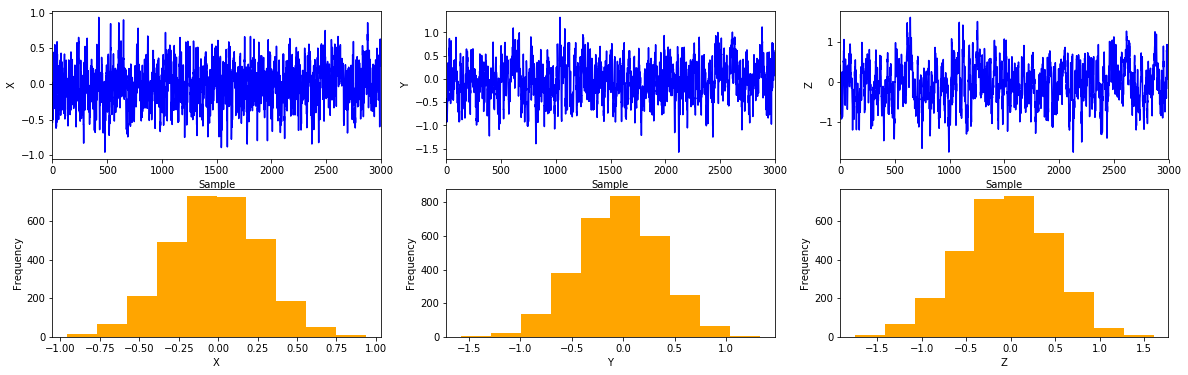

In [6]:
plt.figure(figsize=(20,6))

for i in range(num_vars):
    plt.subplot(2,num_vars, i+1)
    plt.plot(data[:,i], color = 'blue')
    plt.xlabel('Sample')
    plt.ylabel(var_names[i]) 
    plt.xlim((0,num_total_samples))
    
    plt.subplot(2,num_vars, i+1+num_vars)
    plt.hist(data[:,i], color = 'orange')
    plt.xlabel(var_names[i]) 
    plt.ylabel('Frequency')     

The approximately bell-shaped histograms suggest that the variables are marginally Gaussian distributed.

## Preprocessing

Now that the data has been generated, we need to arrange it into the input format required by the PC stable algorithm. Our intention is to create a temporal model that allows us to identify causal interactions that propagate over time. For this, we use time-shifted versions of our variables in the model.

We shift our variables X(t), Y(t) and Z(t) by a shift distance of **D** to create time-shifted versions and arrange them in a matrix as shown in Figure 1 below.

Here we also introduce the notation of __Tier__ that is used to represent variables offset in time from one another with the same time shift. In this example the following variables will be included in each Tier, 

* __Tier 0__ : X(t-3D), Y(t-3D), Z(t-3D)
* __Tier 1__ : X(t-2D), Y(t-2D), Z(t-2D)
* __Tier 2__ : X(t-D), Y(t-D), Z(t-D)
* __Tier 3__ : X(t), Y(t), Z(t)
* __Tier 4__ : X(t+D), Y(t+D), Z(t+D)
* __Tier 5__ : X(t+2D), Y(t+2D), Z(t+2D)
* __Tier 6__ : X(t+3D), Y(t+3D), Z(t+3D)

where D = 1.

As we proceed with the PC algorithm, the variables X(t), Y(t), Z(t) and all of their time-shifted versions, will be represented as separate nodes in the graphical model.

![PC_input_data_structure.JPG](PC_input_data_structure.JPG)
<h4><center>Figure 1: Input matrix for the PC stable algorithm, i.e., the format of pc_data matrix. D = 1 for this example.</center></h4>

This notation indicates that we have shifted the data such that time __t__ is in the middle of the window of time used for the study. Even though this type of a window provides no added advantage to this specific example, it can be easily extended to limit the causal inference study to a specific season or a time frame as often required in climate science applications. See example: *Seasonal_data_extraction.ipynb*. We use the variable `num_plus_minus_shifts` to define the maximum number of shifts either in the positive or negative direction. In this example, `num_plus_minus_shifts = 3`. 

### How many tiers should we use in the study?

Even though there are no hard and fast rules it is important to ensure that we select a large enough number of tiers to address the initialization issues that we discuss later in this notebook. However, at the same time we need to ensure that the time span of the window, which is determined by `num_plus_minus_shifts` and distance between the shifts (`D = shift_dist`), is
selected such that the data used in the study are representative of the time frame of interest and the time resolution of the interactions are meaningful for the study. (This is not relevant for this specific example, but useful for applications in climate.)

In [7]:
# user defined parameters
num_plus_minus_shifts = 3 # number of shifts in the positive or negative directions
num_shifts = 2*num_plus_minus_shifts # total number of time-shifted variables
shift_dist = 1 # shift distance (D)

num_tiers = num_shifts+1 # number of tiers
num_nodes = num_tiers * num_vars # number of nodes in the graphical model

In [8]:
def create_data_matrix_for_pc(standardize = True, **kwargs):

    """
    Creates the input matrix for the PC stable algorithm. This function
    (1) Creates time-shifted versions of the variables. 
    (2) The user can optionally specify the indices that should be used in the study
        by passing 'selective' and 'select_idx'. 
    (2) Standardizes each variable based on user preference.     
    """
    
    selective = kwargs.get('selective', None)
    select_idx = kwargs.get('select_idx', None)
     
    def create_time_shifted_matrix():
        
        "Creates a matrix containing time-shifted versions of the variables as in Figure 1."
        
        num_samples_time_shifted_matrix = num_total_samples-num_shifts*shift_dist
        time_shifted_matrix = np.empty((num_samples_time_shifted_matrix, num_nodes)) # initialize
        for i in range(num_tiers):
            start_time_for_tier = shift_dist*i
            end_time_for_tier = num_total_samples - shift_dist*(num_shifts-i)
            current_cols = range(i*num_vars,(i+1)*num_vars)
            time_shifted_matrix[:, current_cols] = data[start_time_for_tier : end_time_for_tier,:] 

        return time_shifted_matrix
    
    def standardize_data(data):
        
        "Standardizes the data of each node"
        
        means = data.mean(axis=0)
        stds = data.std(axis=0)
    
        return (data - means) / stds 
       

    time_shifted_matrix = create_time_shifted_matrix()
   
    if(selective):
        select_matrix  = time_shifted_matrix[select_idx]
    else:
        select_matrix  = time_shifted_matrix

    if(standardize):
        pc_data = standardize_data(select_matrix) 
        
    else:
        pc_data = select_matrix
        
    return pc_data

Here we provide the option to standardize each node by removing the mean and dividing by the standard deviation. Standardization can be helpful to increase the numerical accuracy of the PC stable algorithm. 

In [9]:
pc_data = create_data_matrix_for_pc(standardize = True)

## PC Stable Algorithm

This section provides a step by step explanation of the PC stable algorithm for time series.

### Step 01: Create a fully connected graph

As mentioned before, all of our variables and their time-shifted versions are now represented as separate nodes in a graph. For the first step, we create a fully connected graph. We use the time constraint that the __*future cannot cause the past*__ to forbid interactions that are not meaningful in a temporal setting. At this step, each node is assumed to interact with every other node excluding the interactions that violate the temporal constraint.

Note that the **implementation presented in this notebook does not allow instantaneous interactions**. That means that variables in the same tier cannot interact with each other (e.g., X(t) cannot interact with Y(t) or Z(t)).

In [10]:
def arrange_node_indices_in_tiers():
    
    "Arranges the indices of the nodes into tiers. Nodes that are at the same time shift are grouped together." 
    
    tiers = np.arange(num_nodes).reshape(num_tiers,num_vars)         
    return tiers

def initialize_graph_with_forbidden_parents(tiers):
    
    """
    Creates a fully connected graph that is based on the temporal constraint that
    the future cannot cause the past.
    In the graph matrix,
    Row index = Index of the parent node
    Col index = Index of the child node
    1   = Potential interaction between the nodes
    """
    
    graph = np.ones((num_nodes, num_nodes)) # initialize a fully connected graph
    np.fill_diagonal(graph,0) # a node cannot interact with itsself
    
   
    # set forbidden edges to zero
    for  current_tier in range(num_tiers):
            forbid_start_node = tiers[current_tier,0]
            current_tier_nodes = tiers[current_tier,:]
            graph[forbid_start_node:,current_tier_nodes] = 0

    return graph 

In [11]:
tiers = arrange_node_indices_in_tiers()
initial_graph = initialize_graph_with_forbidden_parents(tiers)

Following these steps, we get the initial_graph matrix, which we visualize below. In this matrix,
* Row number = Starting node of the interaction (parent)
* Column number = Ending node of the interaction (child)
* 1 = A potential interaction is present

e.g., `initial_graph[0,3] == 1` means that there is a potential interaction from node 0 to node 3.

In [12]:
def highlight_ones(x):
    
    "Highlights the cells that contain values equal to one."
    
    highligt_idx = (x == 1) 
    return ['background-color: peachpuff' if i else '' for i in highligt_idx] 

In [13]:
initial_df = pd.DataFrame(initial_graph).astype(int)
pd.set_option('display.max_columns', num_nodes)
initial_df.style.apply(highlight_ones)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
7,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
8,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
9,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1


---
### Step 02: Eliminate edges using conditional independence tests

Now we try to disprove as many of these assumed interactions/edges by using an appropriate conditional independence test. If two variables are conditionally independent given some subset of nodes in the graph (excluding the two nodes of interest) then these two nodes cannot have a direct interaction between them. The size of the subset used (i.e., the number of nodes in the subset) is referred to as the __order__ of the conditional independence test.

To make this process systematic and computationally efficient, the PC stable algorithm will
* First check whether each pair of variables connected in the graph are independent of each other (order = 0 test). If the variables are independent, then the edge between them will be removed. 
* For the edges that remain after this step, the algorithm will test whether each pair of variables are conditionally independent given another node in the graph (order = 1 test). 
* Continue the process increasing the number of nodes included in the subset (increasing the order) until no more edges can be removed.

The algorithm can be made even more computationally efficient by using the fact that we only need to condition on the potential parents of the nodes to determine conditional independence.  Following this, to determine whether an edge between two nodes N1 and N2 should be eliminated, we check whether N1 and N2 are conditionally independent given the parents of N1. Then we check whether they are conditionally independent given the parents of N2.

### Conditional independence test

In this example, we use a conditional independence test based on partial correlation. 
Partial correlation measures the linear association between two random variables, with the effects of a set of controlling random variables removed. A zero partial correlation between two variables is equivalent to conditional independence provided that the variables are multivariate Gaussian distributed and the relationships between the variables are linear. 
We use the Fisher's Z test with a statistical significance of $\alpha$ to test for zero partial correlation.

In [14]:
def calc_partial_corr_coeff(covariance, x, y, subset ):

    """
    Calculates the partial correlation coefficient between two nodes x and y,
    conditioned on a subset of graph nodes (the subset excludes x and y).
    
    success : indiates whether the calculation executed without error
    r : partial correlation coefficient
    """
    
    # initialize
    success = False
    r = np.nan
    
    epsilon = sys.float_info.epsilon # very small positive number
    pair = [x,y]
    cov_pair = covariance[np.ix_(pair, pair)]
      
    if subset: # partial correlation calculation  
        
        cov_subset = covariance[np.ix_(subset, subset)]
        cov_pair_subset = covariance[np.ix_(pair, subset)]
        cov_subset_pair = covariance[np.ix_(subset,pair)]
               
        # a zero determinant means that the matrix is non-invertible       
        if abs(np.linalg.det(cov_subset)) > epsilon: 
            s = cov_pair - cov_pair_subset @ np.linalg.inv(cov_subset) @ cov_subset_pair
            if((s[0,0]*s[1,1] > 0) and (np.sqrt(s[0,0]*s[1,1]) > epsilon)):
                r = s[0,1]/np.sqrt(s[0,0]*s[1,1])
                success = True
            else:
                print('WARNING: Error dividing by sqrt(s[0,0]*s[1,1])!')
        else:
            print('WARNING: Covariance is close to singular!')
                
    else: # correlation calculation  
        s = cov_pair
        if((s[0,0]*s[1,1] > 0) and (np.sqrt(s[0,0]*s[1,1]) > epsilon)):
            r = s[0,1]/np.sqrt(s[0,0]*s[1,1])
            success = True
        else:
            print('WARNING: Error dividing by sqrt(s[0,0]*s[1,1])!')


    return r, success

In [15]:
def evaluate_cond_independence_fisherZ(x, y, subset, covariance, num_samples_pc, alpha = 0.05, verbose = False):

    """"
    Evaluates whether two nodes x and y are conditionally independent given a subset of nodes.
    Statistically tests for zero partial correlation using the Fisher's Z test to evaluate independence.
    """

    [r,success] = calc_partial_corr_coeff(covariance, x, y, subset )
    cond_indep = np.nan
    p_value = np.nan

    if(success):
        if(abs(r)<1):
            z = 0.5*np.log((1+r)/(1-r)) 
            z0 = 0 
            test_stat = np.sqrt(num_samples_pc - len(subset) - 3)*(z-z0)
            cutoff = norm.ppf(1 - 0.5 * alpha)
            p_value = norm.cdf(test_stat)

            if(abs(test_stat) < cutoff):
                cond_indep = 1 # conditionally independent
                if(verbose):
                    print('Node {} and Node {} are conditionally independent given Nodes {}'.format(x,y,subset))
            else:
                cond_indep = 0 
            
        else: 
            cond_indep = 0
            print('WARNING: Data appears to have deterministic (or almost deterministic) relationships!')
    else:
        print('WARNING: Conditional independece evaluation unsuccessul.\n')

    return [cond_indep, r, p_value, success]

In [16]:
def prune_graph(graph, alpha = 0.05 , verbose = False):
    
    "Removes edges from the graph based on the conditional independence test."
    
    num_samples_pc = np.shape(pc_data)[0]
    done = 0
    order = 0 # size of the subset
    max_order = num_nodes
    covariance = np.cov(pc_data.T) # calculate the covariance matrix

    while not done: 
        graph_temp = np.copy(graph) 
        done = 1

        [row, col] = np.nonzero(graph_temp) # find the existing edges
        
        # check whether x and y are independent given the parents of x or the parents of y
        X = np.hstack((row,col))
        Y = np.hstack((col,row))


        for i in range(len(X)):
            x = X[i]
            y = Y[i]

            potential_parents_of_y = np.nonzero(graph_temp[:,y])
            potential_parents_of_y = np.setdiff1d(potential_parents_of_y,x)
            
            if(len(potential_parents_of_y) >= order):
                done = 0
                comb = combinations(potential_parents_of_y, order) 
                for subset in list(comb): 
                    [cond_indep, r, p_value, success] = evaluate_cond_independence_fisherZ(x, y, subset, 
                                                                        covariance, num_samples_pc, alpha, verbose)
                    if(success):
                        if(cond_indep): # eliminate edge
                            graph[x,y] = 0 
                            graph[y,x] = 0
                            break
                            
        num_of_edges = np.sum(np.triu(graph))
        print('Number of edges left at order {} {}'.format(order,int(num_of_edges)))
        order += 1 # increase the size of the subset
        if(order > max_order):
            break
            
    return graph 

**Caution: Do not ignore any warnings produced while pruning the graph. Warnings can indicate the existence of deterministic relationships/redundancy between the variables.**

In [17]:
pruned_graph = prune_graph(np.copy(initial_graph), alpha = 0.01, verbose = False)

Number of edges left at order 0 176
Number of edges left at order 1 65
Number of edges left at order 2 30
Number of edges left at order 3 30


Many of the assumed initial connections are pruned/removed from the graph using the conditional independence test. The sparsity of the graph is determined by $\alpha$. A smaller $\alpha$ will result in a more sparse graph.

In [18]:
pruned_df = pd.DataFrame(pruned_graph).astype(int)
pd.set_option('display.max_columns', num_nodes)
pruned_df.style.apply(highlight_ones)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


### Step 03: Determine edge directions

The final step of the PC algorithm is to determine the directionality of the edges, such that edges are oriented from cause to effect. The original version of PC uses additional conditional independence tests and user-specified constraints to determine these directions. However, as we do not allow instantaneous edges in this implementation, the directionality of the edges depend entirely on the time constraint that the future cannot cause the past. At this point, we need not follow any additional steps to determine edge directions as the temporal constraints have been already incorporated into our graph.

## Post processing

The information in the pruned graph matrix is with respect to the node indices. In this section, we extract the required information out of this matrix and create a graphical representation that shows a summary of the potential causal interactions. 

In [19]:
def get_directed_edge_details():
    
    """ 
    Extracts the edges/interactions from the pruned_graph.
    Creates a data frame that contains information of the Parent, Child, Delay and Starting Tier of each edge.
    """
    
    # create a mapping between node indices and their tier, variable name information.
    k = 0
    node_def_var = np.empty(num_nodes)
    node_def_tier = np.empty(num_nodes)
    for j in range(num_tiers):
        for i in range(num_vars):
            node_def_var[k] = i 
            node_def_tier[k] = j
            k += 1

    # extract the edges from the pruned_graph matrix        
    [parent,child] = np.where(pruned_graph==1)
    # calculate delay of the interaction taking shift_dist to account
    delay = (node_def_tier[child] - node_def_tier[parent])*shift_dist 
    
    # create a Pandas data frame to contain all the information
    directed_edge_df = pd.DataFrame({'Parent': node_def_var[parent],
                                     'Child': node_def_var[child],
                                     'Delay': delay,
                                     'Start_Tier': node_def_tier[parent]}).astype(int)
    return directed_edge_df

As the first step, we look at the number of edges that originate from each tier. It is possible that many edges remain without being pruned in the first few tiers. This is because these tiers have limited past information to condition on. In this notebook, we refer to this as the __initialization issue__.

In [20]:
def visualize_directed_edge_counts_by_tier():
    
    """
    Plots the number of edges/interactions that originate from each tier.
    This plot can be useful to identify initialization issues.
    """
    
    num_auto = np.zeros([num_tiers]) # number of auto-correlations
    num_cross = np.zeros([num_tiers]) # number of cross-correlations
    num_total = np.zeros([num_tiers]) # total number of edges

    # count the number of edges that originate from each tier
    for current_tier in range(num_tiers):
        idx = np.where(directed_edge_df['Start_Tier'] == current_tier)
        auto = np.where(directed_edge_df['Parent'].iloc[idx]== directed_edge_df['Child'].iloc[idx])
        num_auto[current_tier] = np.shape(auto)[1]
        num_total[current_tier]= np.shape(idx)[1]
        num_cross[current_tier] = num_total[current_tier] - num_auto[current_tier]
    
    # create visualization
    plt.plot(range(num_tiers),num_auto, label = 'Auto', marker = 'o')
    plt.plot(range(num_tiers),num_cross,label = 'Cross', marker = 'o')
    plt.plot(range(num_tiers),num_total,label = 'Total', marker = 'o')
    plt.ylabel('Number of edges')
    plt.xlabel('Starting tier')
    plt.legend(loc='best')
    plt.title('Number of edges originating from each tier')

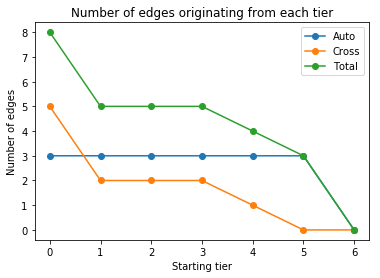

In [21]:
directed_edge_df = get_directed_edge_details()
visualize_directed_edge_counts_by_tier()

Here we plot the total number of edges originating from each tier in Green. Out of these edges, some edges will be auto-correlations (e.g., X(t-1)$\rightarrow$X(t)) and the rest will be cross-correlations (e.g., X(t-2)$\rightarrow$Y(t)).


In this plot, we can see a considerably larger number of edges originating from Tier 0. As this large number of edges is most likely due to initialization issues, we will exclude these edges from the analysis. The user has to determine how many initial tiers need to be excluded from the study. For this example, based on the total number of edges, we will exclude at least the first tier. 

For practical applications that use climate data, identifying the number of tiers to exclude may not be this clear-cut. We recommend to always *at least* exclude the first tier. 

In [22]:
def handle_initialization(num_tiers_to_drop = 1):
    
    """
    Excludes the edges that originate from the initial tiers to handle initialization issues.
    The number of tiers to exclude has to be determined by the user.
    """
    
    # extract edges that do not originate from a restricted tier
    idx_after_drop = np.where(directed_edge_df['Start_Tier'] > (num_tiers_to_drop-1))
    
    # identify edges that are unique based on the Parent variable, Child variable and the Delay of the interaction.
    # count the number of times each of the unique edges occur
    [unique_arrow_details,counts] = np.unique(directed_edge_df[['Parent','Child','Delay']].iloc[idx_after_drop], 
                                              return_counts=True, axis=0)
    
    # create a data frame containing the unique edge information
    unique_edges = pd.DataFrame(np.hstack((unique_arrow_details,counts[:, np.newaxis])), 
                                columns = ['Parent','Child','Delay', 'Counts'])
    
    return unique_edges

In [23]:
num_tiers_to_drop = 1
unique_edges = handle_initialization(num_tiers_to_drop)

The temporal model in this example consists of a total of 7 Tiers (0-6). The time-shifted variables in the adjacent Tiers are 1 time step apart. Now that we have excluded interactions originating from Tier 0, we will continue to study the interactions that originate from the remaining Tiers 1-6.

For example, if we are interested in studying interactions that occur with a time delay of 1 time step (e.g., X(t-1)$\rightarrow$X(t)), we can expect this type of an interaction to occur a maximum of 5 times in our temporal model (between Tiers 1-2, 2-3, 3-4, 4-5 and 5-6).
Similarly, an interaction with a delay of 2 time steps can occur a maximum of 4 times. 

We summarize the interactions, their delays and the number of times they are repeated in the temporal model below. If there is a robust causal signal between two variables, we'd expect that interaction to be consistent and repeat many times in our temporal model. 
If the interactions are inconsistent, this can suggest false discoveries. 

We highlight temporally consistent interactions in the summary table below using a user-defined threshold value (0.7 in this example). As mentioned before, an interaction with a delay of 1 time step can occur a maximum of 5 times. We will call such an interaction **temporally consistent** if it occurs at least 3 times in the temporal model (floor(5$\times$0.7) = 3).

In [24]:
def summarize_results():
    
    """
    Creates a summarized pivot table of the interactions based on their delay.
    This pivot table shows how many times an interaction has repeated in the temporal model. 
    """
     
    edge_labels = []
    
    # create labels for the interactions using the variable names
    for i in range(len(unique_edges.index)):
        parent = unique_edges['Parent'][i]
        child = unique_edges['Child'][i]
        edge_labels.append('{} --> {}' .format(var_names[parent], var_names[child]))

    # create a summary of the edges based on delay - shows how many times each edge repeated.
    edge_data_frame = pd.DataFrame({'Interaction': edge_labels,
                 'Delay:': unique_edges['Delay'],
                 'Count': unique_edges['Counts']})
    edge_summary = pd.pivot_table(edge_data_frame, values='Count', index='Interaction',columns='Delay:',  fill_value=0)    

    return edge_summary

In [25]:
edge_summary = summarize_results()
unique_delays = edge_summary.columns.values 
max_count_per_delay = num_tiers - num_tiers_to_drop - unique_delays/shift_dist

def highlight_consistent(s, max_counts, threshold = 0.7):
    
        "Highlights temporally consistent interactions based on a user defined threhold."
        is_consistent = (s >= np.floor(max_counts*threshold)) # the calculation is done for each row.
        return ['background-color: sandybrown' if v else '' for v in is_consistent] 

    
thresh = 0.7 # defined by the user
edge_summary.style.apply(highlight_consistent, max_counts = max_count_per_delay , 
                   threshold = thresh , axis = 1, subset = unique_delays)

Delay:,1,2,3
Interaction,,,
X --> X,5,0,0
X --> Y,0,4,0
Y --> Y,5,0,0
Y --> Z,0,0,3
Z --> Z,5,0,0


Now we plot the temporally consistent interactions as a graph.

In [26]:
def draw_graph_of_consistent_interactions(max_delay_to_plot = max(unique_edges['Delay'])):
    
    """
    Plots temporally consistent interactions as a graph using Graphviz. 
    User can optionally determine the maximum delay to plot.
    """
    
    # extract the edges are temporally consistent
    unique_edges['Max_Possible_Count'] = num_tiers - num_tiers_to_drop - unique_edges['Delay']/shift_dist
    plot_idx = np.where(np.array(unique_edges['Counts'] >= np.floor(unique_edges['Max_Possible_Count'] * thresh))
             & np.array(unique_edges['Delay'] <= max_delay_to_plot)) 
    edges_to_draw = unique_edges.iloc[plot_idx]
    
    
    edge_dict = edges_to_draw.groupby(['Parent','Child']).groups
    edge_keys = list(edge_dict.keys())
    
    dot = Digraph()
    dot.attr('node', style='filled', color='lightblue2')

    for i in range(len(edge_keys)):
        temp = edges_to_draw['Delay'][edge_dict[edge_keys[i]]]
        text = ','.join(map(str, temp))
        parent_idx = edge_keys[i][0]
        child_idx  = edge_keys[i][1]
        dot.edge(var_names[parent_idx],var_names[child_idx], color = 'grey',label = text)
        
    return dot

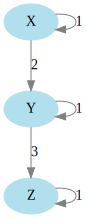

In [27]:
dot_graph = draw_graph_of_consistent_interactions()
dot_graph

Note that this is a **summarized** graphical model. The directed edges or arrows between the graph nodes indicate the presence of potential causal interactions. The numbers alongside the arrows indicate the delay of the interactions. For example, the arrow from X to Y in this graph indicates that there is potential interaction from X to Y at a delay of 2.

We have the option to restrict the interactions that are included in the graph by specifying the maximum delay to plot (`max_delay_to_plot`) in the `draw_graph_of_consistent_interactions` function. Even though it is not required for this example, it can be useful in practical applications. For example, say we try to study interactions that occur with a delay of 5 time steps using our temporal model. After handling initialization issues, this type of interaction can only occur once in the model: between Tiers 1 and 6.
As we can no longer determine whether this interaction is actually temporally consistent or whether it is just a false discovery, we suggest refraining from interpreting such interactions.

### __Final remarks__

* This method assumes that the time series variables are **stationary**. Therefore, always remove the seasonal cycle and any other trends from the data as a preprocessing step.

* It is always important to remember that the interactions identified by this method are only **potential causal connections.** Therefore, any result obtained need to be further augmented by physical understanding. 

* As the conditional independence test used in this example assumes that the relationships between the variables are **linear**, it can be of limited use for certain applications in climate science where the relationships are expected to be highly nonlinear.

* When using this method for practical applications, we suggest you to compare the models for different statistical significance values ($\alpha$). Moving from a larger $\alpha$ to a smaller one, you should see that some of the existing edges are being pruned out from the graph. If you see unexpected changes in the edges (e.g., an edge is present at small $\alpha$, but not present at larger $\alpha$) this can be indicative of a too small sample size.